# Notebook for testing ingest of UC Davis fits files

Initially written 29 Jan 2019 by Craig Lage.
The notebook tests the ingestion of both E2V and ITL fits files from the UC Davis camera and verifies that the image assembly is correct.

### Setup

Before running this notebook, you'll need to set up the `obs_lsst` package. 
Step-by-step instructions:

1. Start a terminal in JupyterLab. In the terminal, setup the Stack with the command `source /opt/lsst/software/stack/loadLSST.bash` and then issue the command `setup lsst_distrib` to allow you to run scons in a subsequent step.

2. Create and/or switch into a folder where you want to put your local versions of the LSST Stack . For me, this is ~/alternate_branches/)

Run the following commands

```
git clone --branch tickets/DM-17437 https://github.com/lsst/obs_lsst.git
cd obs_lsst
setup -k -r .
scons
```

3. Add `setup -k -r alternate_branches/obs_lsst` to `$HOME/notebooks/.user_setups`.

4. Restart your kernel.

Just for fun, check what version of the Stack you are using. This notebook has been tested on `w_2019_4`.

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-3-g242c589+5 	current w_2019_04 setup


In [2]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
from astropy.io import fits
import os
from lsst.geom import Point2I, Extent2I, Box2I

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr.assembleCcdTask import AssembleCcdTask, AssembleCcdConfig


In [3]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions above.

In [4]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [5]:
#E2V spots
E2V_REPO_DIR = '/project/bootcamp/cslage/repo_e2v_29jan19'
E2V_FITS_DIR = '/project/bootcamp/cslage/e2v_fits_files/target'
! rm -rf /project/bootcamp/cslage/repo_e2v_29jan19
! mkdir /project/bootcamp/cslage/repo_e2v_29jan19
! echo "lsst.obs.lsst.ucd.UcdMapper" > /project/bootcamp/cslage/repo_e2v_29jan19/_mapper

fitsFileList = []
for f in os.listdir(E2V_FITS_DIR):
    fitsFileList.append(os.path.join(E2V_FITS_DIR, f))
print(fitsFileList)
args = E2V_REPO_DIR
for fitsFile in fitsFileList:
    args += " "
    args += fitsFile

# Ingest the  target image
! ingestImages.py {args}

['/project/bootcamp/cslage/e2v_fits_files/target/E2V-CCD250-112-04_flat_flat_056_20181108162929.fits']
root INFO: Loading config overrride file '/home/cslage/alternate_branches/obs_lsst/config/ingest.py'
root INFO: Loading config overrride file '/home/cslage/alternate_branches/obs_lsst/config/ucd/ingest.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading Posix exposure registry from /project/bootcamp/cslage/repo_e2v_29jan19
Unable to determine dark time. Setting from exposure time.
ingest INFO: /project/bootcamp/cslage/e2v_fits_files/target/E2V-CCD250-112-04_flat_flat_056_20181108162929.fits --<link>--> /project/bootcamp/cslage/repo_e2v_29jan19/raw/2018-11-09/20181109002934-S00-det000.fits


In [6]:
# Now test the ingestion of an ITL fits file.  I don't have a target image, 
# so we'll use a spots image.
ITL_REPO_DIR = '/project/bootcamp/cslage/repo_itl_29jan19'
ITL_FITS_DIR = '/project/bootcamp/cslage/itl_fits_files/spots/20171201-bf-30um'
! rm -rf /project/bootcamp/cslage/repo_itl_29jan19
! mkdir /project/bootcamp/cslage/repo_itl_29jan19
! echo "lsst.obs.lsst.ucd.UcdMapper" > /project/bootcamp/cslage/repo_itl_29jan19/_mapper

fitsFileList = []
for f in os.listdir(ITL_FITS_DIR):
    fitsFileList.append(os.path.join(ITL_FITS_DIR, f))
print(fitsFileList)
args = ITL_REPO_DIR
for fitsFile in fitsFileList:
    args += " "
    args += fitsFile

# Ingest the  spots image
! ingestImages.py {args}

['/project/bootcamp/cslage/itl_fits_files/spots/20171201-bf-30um/ITL-3800C-002_spot_spot_400_20171201074638.fits']
root INFO: Loading config overrride file '/home/cslage/alternate_branches/obs_lsst/config/ingest.py'
root INFO: Loading config overrride file '/home/cslage/alternate_branches/obs_lsst/config/ucd/ingest.py'
LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading Posix exposure registry from /project/bootcamp/cslage/repo_itl_29jan19
Unable to determine dark time. Setting from exposure time.
ingest INFO: /project/bootcamp/cslage/itl_fits_files/spots/20171201-bf-30um/ITL-3800C-002_spot_spot_400_20171201074638.fits --<link>--> /project/bootcamp/cslage/repo_itl_29jan19/raw/2017-12-01/20171201154643-S00-det002.fits


[20181109002934]


Unable to determine dark time. Setting from exposure time.


Assembled data size should be 4004x4096: (4004, 4096)


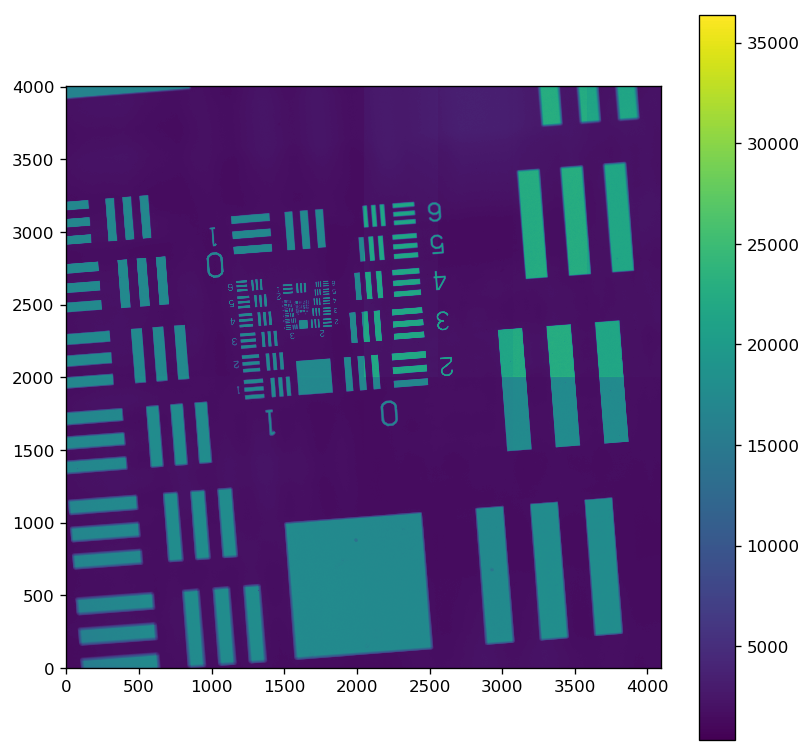

In [7]:
# Now we test the assembly of the E2V target image
# The target image now looks to be assembled correctly.  See below.
e2v_butler = Butler(E2V_REPO_DIR)
visits = e2v_butler.queryMetadata('raw', ['visit'], dataId={})
print(visits)
exposure = e2v_butler.get('raw', dataId={'visit': visits[0],'detector':0, 'detectorName':'S00','raftName':'R00'})
assConfig = AssembleCcdConfig()
assTask = AssembleCcdTask(config=assConfig)
assembled_image = assTask.assembleCcd(exposure)
print("Assembled data size should be 4004x4096:", assembled_image.image.array.shape)
testImage = assembled_image.getMaskedImage().getImage()
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.imshow(testImage.array,origin='lower')
plt.colorbar()

[20171201154643]


Unable to determine dark time. Setting from exposure time.


Assembled data size should be 4000x4072: (4000, 4072)


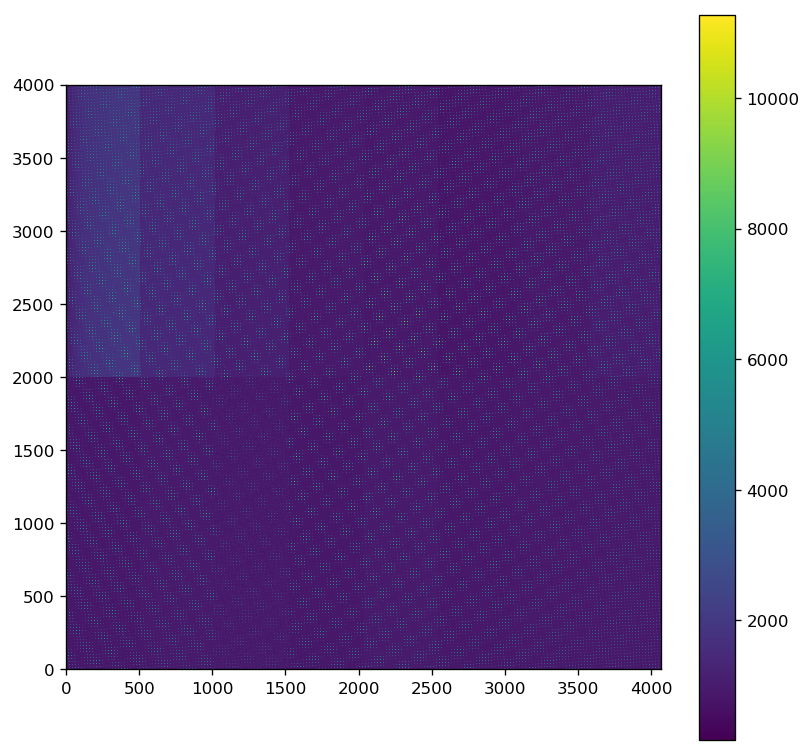

In [8]:
itl_butler = Butler(ITL_REPO_DIR)
visits = itl_butler.queryMetadata('raw', ['visit'], dataId={})
print(visits)
exposure = itl_butler.get('raw', dataId={'visit': visits[0],'detector':2, 'detectorName':'S00', 'raftName':'R02'})
assConfig = AssembleCcdConfig()
assTask = AssembleCcdTask(config=assConfig)
assembled_image = assTask.assembleCcd(exposure)
print("Assembled data size should be 4000x4072:",assembled_image.image.array.shape)
testImage = assembled_image.getMaskedImage().getImage()
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.imshow(testImage.array,origin='lower')
plt.colorbar()

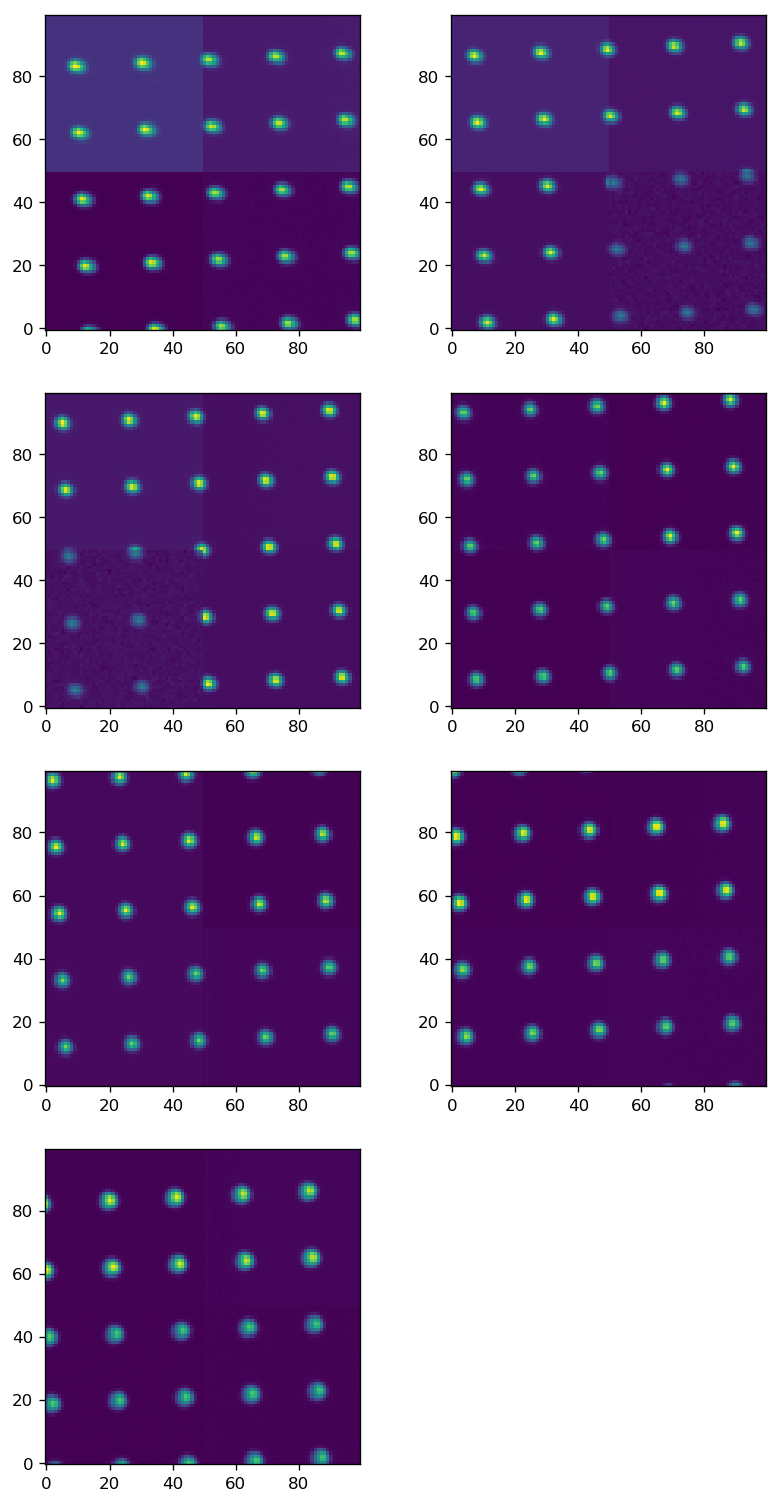

In [9]:
# Let's plot the intersection of the 4 segments to make sure it is assembled correctly.
# Looks OK now.
plt.figure(figsize=(8,16))
plotcounter = 0
for i in range(1,8):
    plotcounter += 1
    plt.subplot(4,2,plotcounter)
    xstart = 509 * i - 50
    xstop = xstart + 100
    plt.imshow(testImage.array[1950:2050,xstart:xstop], origin='lower')
